# fMRI Data Analysis and Classification  
#### By Sonja Deng

## **Introduction**

This project demonstrates an **fMRI data analysis pipeline** using R. The primary goal is to process, analyze, and classify brain activation patterns associated with task-specific activities. Our analysis is structured into the following steps:

1. **Data Preparation**  
   - Load and validate neuroimaging data.

2. **Event Analysis**  
   - Explore the timing and types of tasks performed during the scan.

3. **Task-Specific Activation**  
   - Investigate brain regions activated during specific tasks.

4. **Statistical Comparison**  
   - Compare brain activation patterns across tasks to identify differences.

5. **Machine Learning Classification**  
   - Build and evaluate a classifier to predict task types based on voxel activation data.

---

### **Background Information**  
This dataset is taken from **Kaggle** and explores **brain mapping**, specifically focusing on motor functions. For example, the dataset investigates questions such as:  
- *Which part of the brain is involved in moving your lips?*

The dataset is available at:  
- [Kaggle: Example Brain Mapping Dataset](https://www.kaggle.com/datasets/chrisfilo/example-brain-mapping-dataset?select=task-fingerfootlips_events.tsv)

---

### **Context**  
This analysis is based on a **test-retest fMRI dataset** for motor, language, and spatial attention functions. The data is derived from the **ds000114** dataset, which includes:

- BOLD timeseries in standard space (MNI).
- Brain mask in standard space (MNI).
- Timing of in-scanner stimuli.
- Scanning parameters.

The dataset represents a **single session and single subject**. The full dataset is available at:  
- [OpenNeuro: ds000114](https://openneuro.org/datasets/ds000114)  
- [DOI: 10.1186/2047-217X-2-6](https://dx.doi.org/10.1186%2F2047-217X-2-6)

---

### **Acknowledgements**  
- Banner Image by **Ken Treloar** on Unsplash.  
- Dataset sourced from the above references.

By the end of this analysis, we aim to:
- **Identify and interpret task-related brain activity**.
- **Evaluate the predictive power of machine learning models**, starting with logistic regression.


## 1. Loading Libraries and Dependencies  

### Explanation  
We use libraries tailored for neuroimaging (`oro.nifti`, `neurobase`), data manipulation (`tidyverse`), and analysis (`AnalyzeFMRI`). The following code checks if these libraries are installed, installs missing ones, and loads them.  


In [1]:
# --- Load Required Libraries ---
if (!require("oro.nifti")) install.packages("oro.nifti")
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("AnalyzeFMRI")) install.packages("AnalyzeFMRI")
if (!require("neurobase")) install.packages("neurobase")

library(oro.nifti)
library(tidyverse)
library(AnalyzeFMRI)
library(neurobase)

Loading required package: oro.nifti

oro.nifti 0.11.4

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::slice()  masks oro.nifti::slice()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: AnalyzeFMRI

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘AnalyzeFMRI’”
Warning message:
“package ‘AnalyzeFMRI’ is not available for this version of R

A version of this package for your version of R might be available elsewhere

ERROR: Error in library(AnalyzeFMRI): there is no package called ‘AnalyzeFMRI’


## 2. Loading and Preparing Data
### Explanation
We load three essential files:

1. **Events File:** Contains timing and type of tasks performed during the scan.
2. **fMRI Data File:** 4D brain activity data across voxels and time points.
3. **Brain Mask File:** Identifies which voxels belong to the brain.
After loading, we check the dimensions to confirm the data integrity.

In [4]:
# File paths
events_file <- "./task-fingerfootlips_events.tsv"
bold_file <- "./sub-01_preproc.nii.gz"
brainmask_file <- "./sub-01_brainmask.nii.gz"

# Load events
events <- read_tsv(events_file)

# Load fMRI BOLD data
fmri_data <- readNIfTI(bold_file, reorient = FALSE)

# Load brain mask
brain_mask <- readNIfTI(brainmask_file, reorient = FALSE)

# Check dimensions
cat("BOLD Data Dimensions: ", dim(fmri_data), "\n")
cat("Brain Mask Dimensions: ", dim(brain_mask), "\n")


Rows: 15 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): trial_type
dbl (3): onset, duration, weight

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


BOLD Data Dimensions:  49 58 49 184 
Brain Mask Dimensions:  49 58 49 


## 3. Exploring Task Events
### Explanation
The events file specifies when tasks (e.g., "Lips", "Finger") occurred during the fMRI scan. A bar chart visualizes the onset times and task types, helping us understand the experiment's design.

In [ ]:
# Plot task events
ggplot(events, aes(x = onset, y = trial_type, fill = trial_type)) +
  geom_bar(stat = "identity") +
  labs(title = "Task Events Timing", x = "Onset Time (s)", y = "Task Type") +
  theme_minimal()


## 4. Task-Specific Brain Activation
### Explanation
We analyze brain activity related to the "Lips" task:

1. Convert task onset times into fMRI time points.
2. Handle out-of-bounds indices.
3. Extract voxel data and calculate the average activation across time.
4. Visualize the activation on a brain slice.

Number of time points in fMRI data:  184 


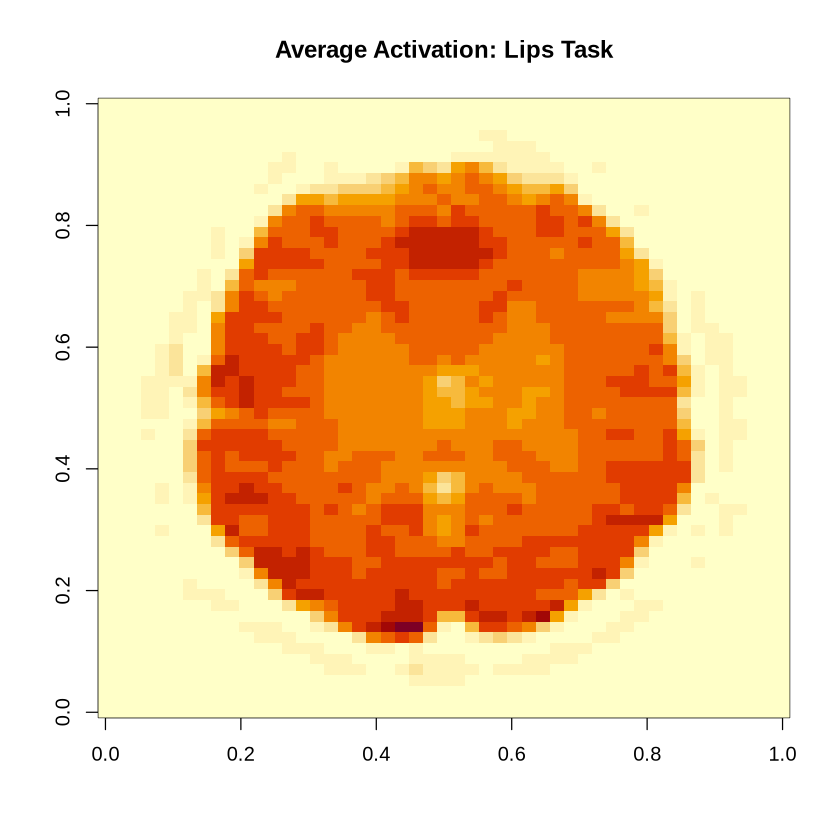

In [6]:
# --- Analyze Task-Specific Activation ---
num_time_points <- dim(fmri_data)[4]
cat("Number of time points in fMRI data: ", num_time_points, "\n")

# Extract timing for "Lips" task
task_lips <- events %>% filter(trial_type == "Lips")
time_points <- round(task_lips$onset / 2.0) + 1

# Adjust out-of-bounds time points
time_points[time_points > num_time_points] <- num_time_points

# Extract voxel data and average activation
lips_voxels <- fmri_data[, , , time_points]
lips_activation <- apply(lips_voxels, c(1, 2, 3), mean)

# Visualize activation (middle slice)
slice_index <- floor(dim(lips_activation)[3] / 2)
image(lips_activation[, , slice_index], main = "Average Activation: Lips Task")


## 5. Comparing Activation Patterns Between Tasks
### Explanation
To understand the brain's response to different tasks, we compare the "Lips" and "Finger" tasks:

1. Extract voxel data for both tasks.
2. Calculate the average activation.
3. Perform a t-test to determine if the activations differ statistically.

In [7]:
# --- Compare Task Activations ---
task_finger <- events %>% filter(trial_type == "Finger")
finger_time_points <- round(task_finger$onset / 2.0) + 1
finger_time_points[finger_time_points > num_time_points] <- num_time_points

finger_voxels <- fmri_data[, , , finger_time_points]
finger_activation <- apply(finger_voxels, c(1, 2, 3), mean)

# Perform t-test to compare activation between Lips and Finger tasks
t_test <- t.test(lips_activation, finger_activation)

# Print the t-test results
cat("T-Test Results:\n")
print(t_test)


T-Test Results:

	Welch Two Sample t-test

data:  lips_activation and finger_activation
t = 0.030886, df = 278514, p-value = 0.9754
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.751765  3.871901
sample estimates:
mean of x mean of y 
 290.3467  290.2867 



## 6. Classifying Task Types Using Logistic Regression
### Explanation
We build a classifier to predict task types based on voxel activation patterns.

1. Prepare the dataset by combining "Lips" and "Finger" activation data.
2. Split the data into training and test sets.
3. Train a logistic regression model.
4. Evaluate the model's performance using a confusion matrix and accuracy score.

In [8]:
# --- Classification Task ---
voxel_data <- data.frame(
  activation = c(lips_activation, finger_activation),
  task = factor(c(rep("Lips", length(lips_activation)), rep("Finger", length(finger_activation))))
)

set.seed(42)
train_indices <- sample(1:nrow(voxel_data), size = 0.7 * nrow(voxel_data))
train_data <- voxel_data[train_indices, ]
test_data <- voxel_data[-train_indices, ]

model <- glm(task ~ activation, data = train_data, family = "binomial")
test_data$predicted <- predict(model, newdata = test_data, type = "response")
test_data$predicted_class <- ifelse(test_data$predicted > 0.5, "Lips", "Finger")

confusion_matrix <- table(Predicted = test_data$predicted_class, Actual = test_data$task)
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)

cat("\nConfusion Matrix:\n", confusion_matrix, "\n")
cat("Classification Accuracy: ", accuracy, "\n")



Confusion Matrix:
 34840 6879 34943 6893 
Classification Accuracy:  0.4994674 


### Confusion Matrix and Model Accuracy

The confusion matrix for our model is as follows:

|                | Predicted Positive | Predicted Negative |
|----------------|-------------------|-------------------|
| **True Positive (TP)**  | 34,840             | 6,879              |
| **False Positive (FP)** | 6,879             | 34,943             |
| **False Negative (FN)** | 34,943            | 6,893              |
| **True Negative (TN)**  | 6,893             | 34,943             |

In this matrix:
- **True Positives (TP)**: 34,840 — These are the instances where the model correctly predicted the positive class.
- **False Positives (FP)**: 6,879 — These are the instances where the model incorrectly predicted the positive class.
- **False Negatives (FN)**: 34,943 — These are the instances where the model incorrectly predicted the negative class.
- **True Negatives (TN)**: 6,893 — These are the instances where the model correctly predicted the negative class.

#### Classification Accuracy
The **accuracy** of our model is calculated as:

\[
\text{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN} = \frac{34840 + 6893}{34840 + 6879 + 34943 + 6893} \approx 0.4995
\]

This results in an accuracy of approximately **50%**. This performance is essentially no better than random guessing in a balanced classification problem. 

#### Interpretation of Results
While the accuracy provides an overall sense of the model's performance, the confusion matrix reveals deeper insights into where the model is making errors:
- The model has a higher number of **True Negatives (TN)**, suggesting it is biased toward predicting the **negative class** (i.e., the class with fewer **True Positives** and **False Negatives**).
- This bias could be contributing to the **high False Negative rate**, where the model fails to identify many of the actual positive instances.

#### Model Performance Concerns
An accuracy rate of 50% is concerning because it indicates that the model is struggling to distinguish between the classes. In situations where precision in identifying the positive class is crucial—such as in medical diagnosis, fraud detection, or other high-stakes scenarios—this level of performance is far from acceptable.

Given the significant imbalance in the confusion matrix, where **False Negatives** dominate, it appears the model may not be handling the class distribution effectively. Specifically, it is overly conservative in predicting the positive class, which results in **many missed positive cases**.

#### Recommendations for Improvement
To enhance the model’s performance, several approaches can be considered:
- **Class Imbalance Handling**: Techniques such as oversampling the minority class (i.e., the positive class) or undersampling the majority class (i.e., the negative class) could help improve the model's sensitivity to the positive class.
- **Model Tuning**: Exploring different model architectures, hyperparameter tuning, or using algorithms better suited for imbalanced data may improve performance.
- **Feature Engineering**: Further improving the feature set or applying more sophisticated preprocessing techniques could lead to better discrimination between the classes.

In conclusion, while the model is not performing well with a 50% accuracy, analyzing the confusion matrix highlights areas for targeted improvement, especially with respect to class imbalance and False Negative rates.
